# HITL (Human in the Loop)

In [65]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [45]:
# Importer le modèle pré-entraîné de Artifact Registry Google with bentoml

# dvc pull (dossier model)
# bentoml models import /home/cris/mlops/MLOps-project/model/trash_classifier_model.bentomodel
# mettre le chemin absolu du fichier .bentomodel

# Référence au modèle entrainé : tag="trash_classifier_model:ciqmwpguswhiypxm" 
# mobilnet 9 epochs

import bentoml
from bentoml.models import BentoModel
from bentoml.keras import load_model

# Récupérer la dernière version du modèle importé
model_ref = bentoml.models.get("trash_classifier_model:latest")
print(model_ref)

# Charger le modèle
model = load_model(model_ref)

/tmp/ipykernel_34962/2952773994.py:12: BentoMLDeprecationWarning: `bentoml.keras` is deprecated since BentoML v1.4 and will be removed in a future version.
  from bentoml.keras import load_model


Model(tag="trash_classifier_model:ciqmwpguswhiypxm")


In [256]:
print(model_ref.info.metadata)

{}


In [257]:
# Import Dataset

IMG_SIZE = (256, 256)
BATCH_SIZE = 34

ds = tf.keras.utils.image_dataset_from_directory(
    "../data/raw2/train/images/.",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    verbose=1,
)


Found 7324 files.


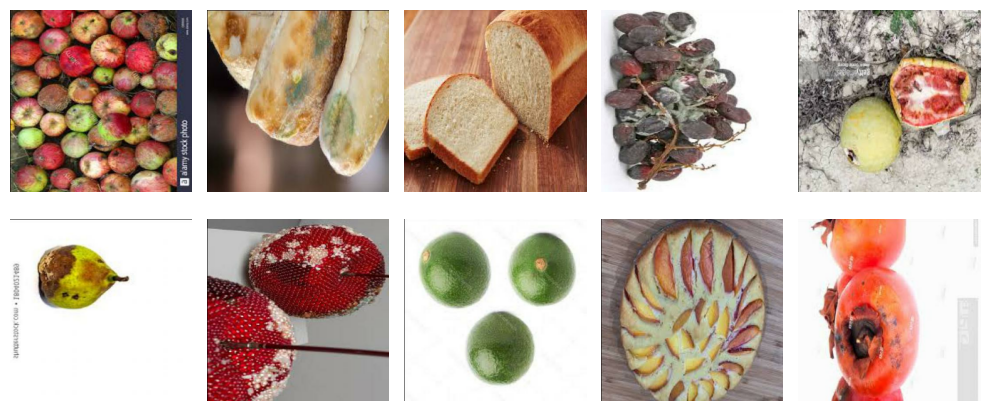

In [258]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images in ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [259]:
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds = ds.map(lambda x: normalization_layer(x))

In [260]:
preds= model.predict(ds)

216/216 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step


In [261]:
probs = tf.nn.softmax(preds, axis=-1).numpy() # # (N, num_classes)

In [262]:
y_pred = np.argmax(probs, axis=-1) # (N,)

In [263]:
data_dir = './../data/raw2/train/images/'

import re
def natural_key(path):
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', path.name)]

data_dir = Path("../data/raw2/train/images")
file_paths = sorted(data_dir.iterdir(), key=natural_key)
noms = [p.name for p in file_paths]

In [264]:
# si la probabilité maximale est inférieure à un seuil, alors on considère que le modèle n'est pas sûr de sa prédiction
threshold = 0.8


uncertain_indices = [i for i, p in enumerate(probs) if np.max(p) < threshold]
print("Indices des images incertaines :", uncertain_indices)

# placer dans un dossier "uncertain_images" les images correspondantes aux indices incertains
import shutil
uncertain_dir = Path("../data/uncertain_images")
uncertain_dir.mkdir(parents=True, exist_ok=True)        
for i in uncertain_indices:
    src = Path(data_dir) / noms[i]
    dst = uncertain_dir / noms[i]
    shutil.copy(src, dst)
print(f"Images incertaines copiées dans le dossier {uncertain_dir}")
print("Prédictions :", y_pred)

Indices des images incertaines : [2, 18, 39, 44, 69, 122, 134, 149, 232, 239, 252, 253, 259, 298, 343, 352, 371, 430, 438, 480, 487, 512, 522, 545, 552, 562, 569, 577, 580, 592, 604, 605, 623, 636, 647, 649, 660, 673, 691, 699, 729, 739, 773, 822, 841, 850, 856, 858, 859, 880, 889, 924, 925, 948, 950, 982, 983, 992, 998, 1006, 1052, 1067, 1078, 1096, 1109, 1122, 1142, 1176, 1188, 1192, 1218, 1229, 1236, 1247, 1296, 1330, 1356, 1370, 1378, 1415, 1427, 1431, 1437, 1456, 1457, 1461, 1486, 1489, 1504, 1516, 1522, 1545, 1550, 1552, 1576, 1603, 1608, 1629, 1630, 1635, 1679, 1711, 1716, 1733, 1742, 1743, 1748, 1759, 1763, 1764, 1773, 1782, 1785, 1787, 1816, 1820, 1874, 1883, 1885, 1895, 1899, 1919, 1932, 1940, 1946, 1952, 1969, 1972, 1977, 1978, 1983, 1985, 2027, 2047, 2065, 2098, 2120, 2139, 2157, 2159, 2161, 2174, 2176, 2179, 2182, 2192, 2196, 2199, 2200, 2203, 2209, 2224, 2232, 2239, 2243, 2247, 2248, 2250, 2255, 2257, 2259, 2271, 2274, 2321, 2322, 2330, 2332, 2342, 2344, 2378, 2384, 2401,

In [265]:
# prendre le fichier annotations.csv exporté de label studio
import pandas as pd
annotations_df = pd.read_csv("../data/annotations.csv")

labels = annotations_df['choice']

In [194]:
len(uncertain_indices)


701

In [195]:
annotations_df.shape

(562, 8)

In [196]:
# Le csv est faux ne contient tout les labels !!!!!

# Entrainment avec des labels fournis par des humains via Label Studio

In [1]:
# Labels:
#    0: cardboard
#    1: glass
#    2: metal
#    3: paper
#    4: plastic
#    5: trash

def transform_labels_to_int(label : str) -> int:
    match label:
        case 'cardboard':
            return 0
        case 'glass':
            return 1
        case 'metal':
            return 2
        case 'paper':
            return 3
        case 'plastic':
            return 4
        case 'trash':
            return 5

In [2]:
import os
import re
data_dir = './../data/raw2/test/images/'

# --- Fonction de tri naturel personnalisée (utilisant re) ---
def tri_naturel_cle(texte):
    """
    Clé utilisée par la fonction sorted() pour trier le texte naturellement.
    """
    # Sépare les parties numériques des parties textuelles
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', texte)]

# --- Code principal corrigé ---

# 1. Obtenez la liste complète des noms de fichiers bruts
noms_bruts = os.listdir(data_dir)

# 2. Triez la liste en utilisant la fonction de tri naturel comme clé.
# Ne modifiez pas les noms avant de les trier !
noms_tries = sorted(noms_bruts, key=tri_naturel_cle)
noms = noms_tries


In [3]:
# Créer les labels pour les images incertaines

classes = ['biodegradable', 'cardboard', 'glass', 'metal', 'paper', 'plastic']

labels = []
for name in noms:
    for c in classes:
        if name.startswith(c):
            labels.append(c)
            break

for i in range(len(labels)):
    if labels[i] == 'biodegradable':
        labels[i] = 'trash'


In [5]:
# Convertir les labels list en dataframe et après exporter
import pandas as pd

annotations_hitl_df = pd.DataFrame(labels, columns=['choice'])
annotations_hitl_df.to_csv("./../data/labels_raw2_test.csv", index=False)

In [71]:
# Importer les labels depuis le csv
annotations_hitl_df = pd.read_csv("../data/annotations_hitl1.csv")
labels = annotations_hitl_df['choice'].tolist()

In [72]:
labels = [transform_labels_to_int(label) for label in labels]
print(labels)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [73]:
len(labels)

975

In [55]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

In [56]:
np.array(labels)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [57]:
ds = tf.keras.utils.image_dataset_from_directory(
    "../data/uncertain_images/.",
    labels=labels,
    label_mode='int',
    color_mode="rgb",
    verbose=1,
)

Found 975 files belonging to 6 classes.


In [58]:
ds = ds.shuffle(buffer_size=len(labels), seed=seed)
cardinality = ds.cardinality().numpy()
train_size = int(cardinality * 0.8)

ds_train = ds.take(train_size)
ds_test  = ds.skip(train_size)


In [59]:
nom_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# # Normalize the data
# normalization_layer = tf.keras.layers.Rescaling(
#     1.0 / 255
# )
# ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
# ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


In [60]:
import bentoml
from bentoml.models import BentoModel
from bentoml.keras import load_model

# Récupérer la dernière version du modèle importé
model_ref = bentoml.models.get("trash_classifier_model:latest")
print(model_ref)

# Charger le modèle
model = load_model(model_ref)

/tmp/ipykernel_34962/308995564.py:3: BentoMLDeprecationWarning: `bentoml.keras` is deprecated since BentoML v1.4 and will be removed in a future version.
  from bentoml.keras import load_model


Model(tag="trash_classifier_model:ciqmwpguswhiypxm")


In [61]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [62]:
epochs = 1

model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
)

24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - loss: 1.0905 - sparse_categorical_accuracy: 0.7909 - val_loss: 4.0525 - val_sparse_categorical_accuracy: 0.2723


In [63]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.1344 - sparse_categorical_accuracy: 0.2768
Validation loss: 4.13
Validation accuracy: 27.68%


2025-12-12 15:25:17.331895: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


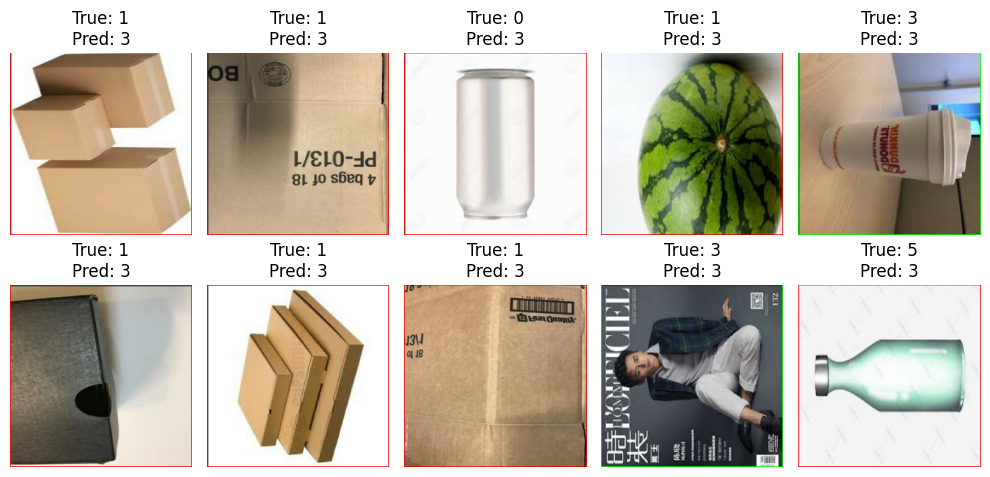

In [64]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy()).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

In [44]:
# Score accuracy, precision and f1-score of model on the test set

preds = model.predict(ds_test)

y_true = tf.concat([y for _, y in ds_test], axis=0).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

# Report scikit-learn classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=nom_labels, output_dict=False)
print("Classification Report:")
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        23
       glass       0.29      0.15      0.20        52
       metal       0.11      0.03      0.05        32
       paper       0.28      0.81      0.42        54
     plastic       0.00      0.00      0.00        29
       trash       0.08      0.06      0.07        17

    accuracy                           0.26       207
   macro avg       0.13      0.18      0.12       207
weighted avg       0.17      0.26      0.17       207



2025-12-12 14:32:27.997337: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defin

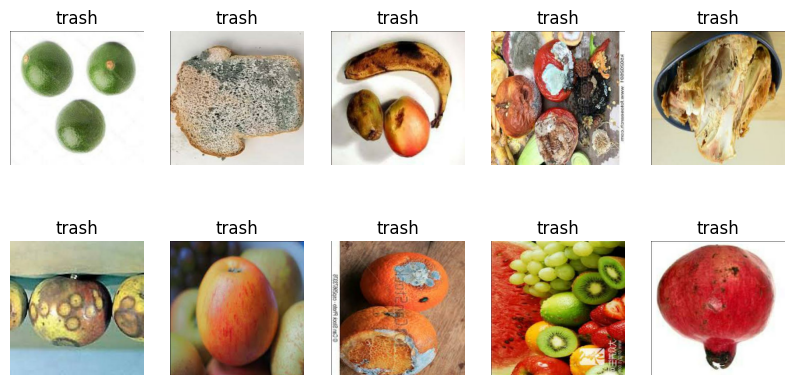

In [413]:
import matplotlib.pyplot as plt

class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]  # adapte si besoin

for images, labels in ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
    break
